**Input:** Text

**Output:** Sentiment Label [0, 1, 2]

- **0:** Negative Sentiment
- **1:** Neutral Sentiment
- **2:** Positive Sentiment

In [45]:
pip install pythainlp

In [46]:
import numpy as np
import pandas as pd

from pythainlp import word_tokenize

from keras import regularizers
from keras import backend as K
from keras.models import Sequential
# from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
# from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
# from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, BatchNormalization, SpatialDropout1D, Dropout

from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
train_df = pd.read_csv('train.csv')


### Preprocess

In [48]:
train_df['length'] = train_df['texts'].apply(word_tokenize).apply(len)
train_df = train_df[train_df['length'] < train_df['length'].quantile(0.95)]
train_df = train_df[train_df['length'] >= train_df['length'].quantile(0.05)]

In [49]:
train_df.category.value_counts()

neu    11893
neg     5956
pos     4092
Name: category, dtype: int64

In [50]:
class_names = np.unique(train_df.category).tolist()
class_names

['neg', 'neu', 'pos']

In [51]:
train_df.sample(n=5)

,category,texts,length
12040,neu,มาไวๆ ไม่งั้นซีวิคกินเรียบ,8
18732,neu,ลำดับที่6 ขี้โม้หน่อย555,7
19580,neu,ได้เเดกเเล้วววววววววววววววววววววววววววววววววววว,4
3085,neu,เห็นแย้ว,3
13318,neg,นี่ไม่โอเคกับ BA Nars สาขาเซนเฟสเชียงใหม่อ่ะ ค...,40


In [52]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### **Preprocess**


#### Tokenizer
Before training, I converted text to numbers because models learn only from numerical. Breaking down long sentences into individual words   simplify the learning process of the model


for example

In [53]:
train_df['texts'][0]
word_tokenize(train_df['texts'][0])

['ประเทศ',
 'เรา',
 'ผลิต',
 'และ',
 'ส่งออก',
 'ยาสูบ',
 'เยอะ',
 'สุด',
 'ใน',
 'โลก',
 'จิง',
 'ป่าว',
 'คับ']

In [54]:
import re

In [26]:
# def preprocess_tokens(tokens):
#     # Remove tokens where any character repeats two or three times consecutively
#     processed_tokens = [re.sub(r'(.)\1{1,3}', '', token) for token in tokens]
#     # Remove empty tokens (if any)
#     processed_tokens = [token for token in processed_tokens if token.strip()]
#     return processed_tokens


In [55]:
# Tokenize using pythainlp
train_df['tokenized_texts'] = train_df['texts'].apply(word_tokenize)


In [56]:
train_df['tokenized_texts'] = train_df['tokenized_texts'].apply(lambda tokens: [token.strip() for token in tokens if token.strip()])
train_df['tokenized_texts']


0        [ประเทศ, เรา, ผลิต, และ, ส่งออก, ยาสูบ, เยอะ, ...
2            [อิ, เหี้ย, ออม, ทำ, กู, อยาก, กิน, เอ็ม, เค]
4                        [สวัสดี, วัน, พุธ, แนน, อะไร, นะ]
5        [ก้อน, ขอบพระคุณ, มาก, ๆ, นะ, คร้าบ, ที่, มาหา...
7                            [ปาก, แดง, กิน, ฟรี, ค่ะ, 😬😬]
                               ...                        
23540                             [แม่, ง, ควาย, ล้วน, นน]
23541     [ดอย, สุเทพ, น้อง, ง, ไป, หมด, แล้ว, ววว, #pm25]
23542                 [ค่า, ชุด, อาจจะ, แพง, กว่า, ส่วนลด]
23543                      [รัฐ, ต้องการ, แค่, ภาษี, ครับ]
23544    [™, ได้, พัฒนา, ระบบ, เข้าสู่, รุ่น, ที่สอง, แ...
Name: tokenized_texts, Length: 21941, dtype: object

In [57]:
# Create a dictionary mapping words to unique integer indices
word_index = {}
for words_list in train_df['tokenized_texts']:
    for word in words_list:
        if word not in word_index:
            word_index[word] = len(word_index) + 1  # Start indexing from 1

# Convert the text sequences to integer sequences based on the word_index
train_df['sequences'] = train_df['tokenized_texts'].apply(lambda words_list: [word_index[word] for word in words_list])

# Get the maximum sequence length
max_length = max(len(sequence) for sequence in train_df['sequences'])
print("Maximum Sequence Length:", max_length)

Maximum Sequence Length: 91


### Padding sequence

<li> help us receive input text sentences with different range for training with neural network that have to fixed size input by multiplying input method like zero padding


for example

Original Sequence 1: `[1, 2, 3]` | Padded Sequence 1: `[0, 1, 2, 3]`

Original Sequence 2: `[4, 5]` | Padded Sequence 2: `[0, 0, 4, 5]`



In [58]:
# Padding sequences
X = pad_sequences(train_df['sequences'], maxlen=max_length)
X[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12, 13], dtype=int32)

In [59]:
X.shape

(21941, 91)

In [60]:
label_mapping = {'neg': 0, 'neu': 1, 'pos': 2}
y_num = train_df['category'].map(label_mapping)

In [61]:
train_df['labels'] = train_df['category'].map(label_mapping)
print(train_df[['labels', 'texts']])


       labels                                              texts
0           1  ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ
2           0                        อิเหี้ยออมทำกูอยากกินเอ็มเค
4           1                            สวัสดีวันพุธ แนน อะไรนะ
5           1  ก้อนขอบพระคุณมากๆนะคร้าบ ที่มาหาก้อนและชมเชยกา...
7           1                                 ปากแดงกินฟรีค่ะ 😬😬
...       ...                                                ...
23540       0                                     แม่งควายล้วนนน
23541       0                   ดอยสุเทพน้องง ไปหมดแล้วววว #pm25
23542       0                           ค่าชุดอาจจะแพงกว่าส่วนลด
23543       1                              รัฐต้องการแค่ภาษีครับ
23544       1  ™ ได้พัฒนาระบบเข้าสู่รุ่นที่สองแล้ว มาดูกันสิว...

[21941 rows x 2 columns]


In [62]:
np.unique(y_num)

array([0, 1, 2])

For the process of changing numerical labels to one-hot vectors:

1. Utilize `to_categorical` to convert numerical labels to one-hot encoded vectors.
2. For instance:
   - 'positive' is represented as [0, 0, 1]
   - 'negative' is represented as [1, 0, 0]
   - 'neutral' is represented as [0, 1, 0]

In [63]:
y = to_categorical(y_num)

# Vocabulary size
vocab_size = len(word_index) + 1
print("Vocabulary size:", vocab_size)


Vocabulary size: 23818


In [64]:
y.shape

(21941, 3)

In [65]:
train_df['tokenized_texts']

0        [ประเทศ, เรา, ผลิต, และ, ส่งออก, ยาสูบ, เยอะ, ...
2            [อิ, เหี้ย, ออม, ทำ, กู, อยาก, กิน, เอ็ม, เค]
4                        [สวัสดี, วัน, พุธ, แนน, อะไร, นะ]
5        [ก้อน, ขอบพระคุณ, มาก, ๆ, นะ, คร้าบ, ที่, มาหา...
7                            [ปาก, แดง, กิน, ฟรี, ค่ะ, 😬😬]
                               ...                        
23540                             [แม่, ง, ควาย, ล้วน, นน]
23541     [ดอย, สุเทพ, น้อง, ง, ไป, หมด, แล้ว, ววว, #pm25]
23542                 [ค่า, ชุด, อาจจะ, แพง, กว่า, ส่วนลด]
23543                      [รัฐ, ต้องการ, แค่, ภาษี, ครับ]
23544    [™, ได้, พัฒนา, ระบบ, เข้าสู่, รุ่น, ที่สอง, แ...
Name: tokenized_texts, Length: 21941, dtype: object

## "LSTM" Model

  Reason why picking up lstm

- LSTM suitable for sequential data, like sentiment analysis "LSTM is designed to capture long range dependency"

- LSTM handling vanishing gradient; memory cell, forget gate, residual connection to help the network remember the previous sentences and forgot unneccessary input and skip connection to prevent vanishing gradient when sentences is long.

- Memory cell, LSTM can store and retrieve information over long periods so it will allow to remember contextual information

How's LSTM work

1. Input Sequences: the input sequences consists of sequence of words. Each words represent as a vector

2. Sequence processing: LSTM process the input one element at a time so it can capture information from earlier parts of the sentences

3. Memory Cells: select remember or forget information over long sequences

4. Gates: LSTM gate control the information in and out
    Input Gate: Decides which information to add to the memory cell.
    Forget Gate: Decides which information to discard from the memory cell.
    Output Gate: Decides what to output based on the current input and the memory cell's content.
5. Backpropagation Through Time
    It propagates the error back through the entire sequence, updating the weights at each time step to improve the model's performance.

Model architecture

Bidirectional LSTM: help the model can read the sentences from the front and backward before decided what it will keep and what it will be in forgot gate.
Since my data is relatively long sentences, i think Bidirectional will help to classify the text and it will be help to capture contextual information

In [66]:
initial_learning_rate = 1e-3
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9
)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0, return_sequences=True)),
    BatchNormalization(),
    Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0)),
    BatchNormalization(),
    Dense(64, activation='tanh', kernel_regularizer=l2(0.01)),
    Dense(3, activation='softmax')
])
optimizer = Adam(learning_rate=initial_learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc',f1_m,precision_m, recall_m])


In [67]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 91, 128)           3048704   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 91, 128)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_2 (Bidirecti  (None, 91, 100)           71600     
 onal)                                                           
                                                                 
 batch_normalization_2 (Bat  (None, 91, 100)           400       
 chNormalization)                                                
                                                                 
 bidirectional_3 (Bidirecti  (None, 100)               60400     
 onal)                                                

### Training

#### Class Weight
- Using class weights to address class imbalance in the dataset ensures that the model gives higher weight to minority classes, preventing them from being overshadowed by the majority class.


In [68]:
early_stopping = EarlyStopping(monitor='val_f1_m', patience=10, restore_best_weights=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_num),  # numerical
                                        y = y_num # numerical
                                    )
class_weights_dict = dict(zip(np.unique(y_num), class_weights))

In [69]:
class_weights_dict

{0: 1.2279494067606895, 1: 0.6149555761091959, 2: 1.787308569566634}

In [70]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], class_weight=class_weights_dict)


Epoch 1/100
549/549 [==============================] - 45s 67ms/step - loss: 1.2609 - acc: 0.5647 - f1_m: 0.5197 - precision_m: 0.6048 - recall_m: 0.4595 - val_loss: 0.9476 - val_acc: 0.6179 - val_f1_m: 0.5790 - val_precision_m: 0.6666 - val_recall_m: 0.5139
Epoch 2/100
549/549 [==============================] - 17s 31ms/step - loss: 0.7110 - acc: 0.7215 - f1_m: 0.7108 - precision_m: 0.7485 - recall_m: 0.6778 - val_loss: 0.8077 - val_acc: 0.6655 - val_f1_m: 0.6589 - val_precision_m: 0.6845 - val_recall_m: 0.6360
Epoch 3/100
549/549 [==============================] - 16s 30ms/step - loss: 0.4864 - acc: 0.8021 - f1_m: 0.7983 - precision_m: 0.8175 - recall_m: 0.7806 - val_loss: 0.8318 - val_acc: 0.6455 - val_f1_m: 0.6434 - val_precision_m: 0.6610 - val_recall_m: 0.6272
Epoch 4/100
549/549 [==============================] - 16s 29ms/step - loss: 0.3763 - acc: 0.8431 - f1_m: 0.8425 - precision_m: 0.8547 - recall_m: 0.8311 - val_loss: 0.9438 - val_acc: 0.6357 - val_f1_m: 0.6293 - val_precisi

#### Evaluation

- **Evaluation Summarization:**
  - Due to the inherent imbalance in my dataset, the focus of the evaluation is on key metrics including precision, F1-score, and recall.
    - Precision: Measuring the accuracy of positive predictions.(How well model predict)
    - F1-score: Balancing precision and recall, particularly important in imbalanced datasets.
    - Recall: Capturing the ability to identify all relevant instances, especially vital for minority classes.


In [71]:
score = model.evaluate(X_val, y_val, verbose=1, batch_size=32)


138/138 [==============================] - 2s 13ms/step - loss: 0.9476 - acc: 0.6179 - f1_m: 0.5790 - precision_m: 0.6666 - recall_m: 0.5139


In [76]:
test_df = pd.read_csv('test.csv')

In [77]:
test_df['tokenized_texts'] = test_df['texts'].apply(word_tokenize)

# Convert the text sequences to integer sequences based on the existing word_index
test_df['sequences'] = test_df['tokenized_texts'].apply(lambda words_list: [word_index.get(word, 0) for word in words_list])

# Padding sequences
X_test = pad_sequences(test_df['sequences'], maxlen=max_length)

test_labels = test_df['category'].map(label_mapping)
y_test = to_categorical(test_labels)


In [78]:
predictions = model.predict(X_test)

predicted_labels = np.argmax(predictions, axis=1)

84/84 [==============================] - 2s 9ms/step


In [79]:
y_test_original = np.argmax(y_test, axis=1)


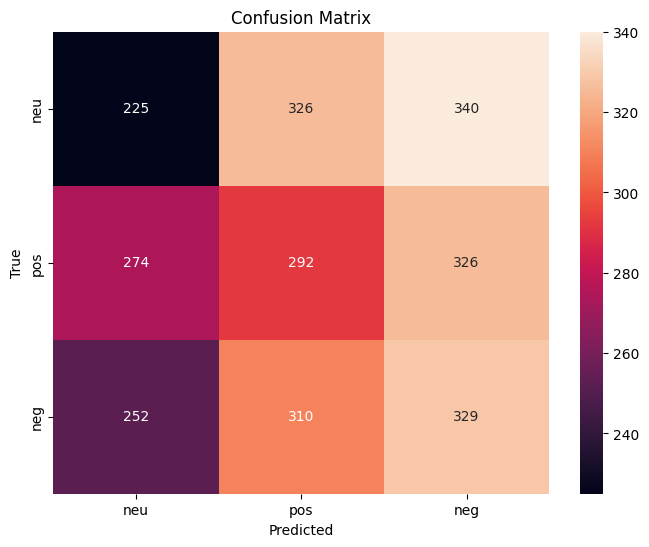

In [80]:
# Evaluate classification report
classification_report(y_test_original, predicted_labels)

conf_matrix = confusion_matrix(y_test_original, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['neu', 'pos', 'neg'], yticklabels=['neu', 'pos', 'neg'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Performance evaluation

<li> Check for the model predict wrong classes

In [81]:
incorrect_indices = np.where(predicted_labels != y_test_original)[0]

num_to_print = min(20, len(incorrect_indices))

for i in range(num_to_print):
    index = incorrect_indices[i]
    print("Index:", index)
    print("Predicted Probabilities:", np.max(predictions[index], axis=0))
    print("Predicted Class:", predicted_labels[index])
    print("True Class:", y_test_original[index])
    print("Text:", test_df['texts'].iloc[index])
    print("\n")


Index: 0
Predicted Probabilities: 0.87281114
Predicted Class: 0
True Class: 1
Text: ซื้อแต่ผ้าอนามัยแบบเย็นมาค่ะ แบบว่าอีห่ากูนอนไม่ได้


Index: 5
Predicted Probabilities: 0.4689116
Predicted Class: 2
True Class: 0
Text: เคล็ดลับที่ขาดไม่ได้ในการป้องกันผิวจากแสงแดด คือการทาครีมกันแดด สาวๆบ้างคนอาจจะคิดว่ามันไม่ใช่เรื่องสำคัญเท่าไหร่ แต่บอกเลยว่า ผิดมาก เพราะแสงแดดสมัยนี้แรงมาก และมีอนุภาพการทำลายผิวสูงมาก ถ้าไม่อยากให้ผิวเราถูกทำร้ายแบบซ้ำๆซาก ควรทาครีมกันแดดที่ดีมีคุณภาพอย่าง Eucerin Sun Age Repair Serum ปัจจุบันครีมกันแดดมีมากมายให้เราเลือกซื้อก็จริง แต่ก็อย่าลืมเลือกสิ่งที่ดีที่สุดให้ตัวเราอย่าง Eucerin Sun Acne oil Control ค่ะ


Index: 6
Predicted Probabilities: 0.6679482
Predicted Class: 0
True Class: 1
Text: สำหรับสูตรของผม คือ Jack Daniel's หวานซ่อนเปรี้ยวชื่อ Jack Yellow Life ส่วนประกอบ Jack Daniel's 2 ชอท น้ำเก๊กฮวย น้ำมะนาว ใบมิ้นท์ เกลือเล็กน้อย วิธีปรุง นำ JackDaniel's มาเขย่ากับน้ำเก๊กฮวย เจือด้วยน้ำมะนาวบางๆ ตกแต่งด้วยใบมิ้น เสริฟด้วยแก้วที่ทาเกลือไว้ที่ปากแก้ว รสชาติที่จ

### Most wrongs predicted classes

  1. Class 1, which represents neutral sentiment, is the most misclassified.
     - This may be due to a higher representation of the neutral class in the dataset.
  2. The neutral class is particularly challenging to determine accurately.


In [82]:
from collections import Counter

misclassified_classes_counter = Counter(y_test_original[incorrect_indices])

# Find the most frequently misclassified class
most_wrong_class, misclassification_count = misclassified_classes_counter.most_common(1)[0]

for predicted_class, misclassification_count in misclassified_classes_counter.items():
    print(f"Predicted Class: {predicted_class}, Misclassification Count: {misclassification_count}")

Predicted Class: 1, Misclassification Count: 600
Predicted Class: 0, Misclassification Count: 666
Predicted Class: 2, Misclassification Count: 562


### Test model evaluation

In [83]:
input_text = "สวัสดีวันนี้วันพฤหัสบดี วันดีๆ"


In [84]:
input_sequence = word_tokenize(input_text)

input_indices = [word_index[word] for word in input_sequence if word in word_index]

# Pad the sequence
padded_input = pad_sequences([input_indices], maxlen=max_length, padding='post')  # Assuming 'post' padding

# Make predictions
predicted_probabilities = model.predict(padded_input)

predicted_label = np.argmax(predicted_probabilities, axis=1)[0]

predicted_category = predicted_label

print("Input Text:", input_text)
print("Tokenized Input Sequence:", input_sequence)
print(f"Predicted Category, the ground truth label is {np.unique(train_df.category)}:", predicted_category) # class 2 is positve
print("Predicted Probabilities:", np.max(predicted_probabilities))

1/1 [==============================] - 0s 68ms/step
Input Text: สวัสดีวันนี้วันพฤหัสบดี วันดีๆ
Tokenized Input Sequence: ['สวัสดี', 'วันนี้', 'วัน', 'พฤหัสบดี', ' ', 'วันดี', 'ๆ']
Predicted Category, the ground truth label is ['neg' 'neu' 'pos']: 1
Predicted Probabilities: 0.52809054


In [85]:
input_text = "เมื่อไหร่จะวันศุกร์ ขี้เกียจทำงานน"


In [86]:
input_sequence = word_tokenize(input_text)

input_indices = [word_index[word] for word in input_sequence if word in word_index]

# Pad the sequence
padded_input = pad_sequences([input_indices], maxlen=max_length, padding='post')  # Assuming 'post' padding

# Make predictions
predicted_probabilities = model.predict(padded_input)

predicted_label = np.argmax(predicted_probabilities, axis=1)[0]

predicted_category = predicted_label

print("Input Text:", input_text)
print("Tokenized Input Sequence:", input_sequence)
print(f"Predicted Category, the ground truth label is {np.unique(train_df.category)}:", predicted_category) # class 2 is positve
print("Predicted Probabilities:", np.max(predicted_probabilities))

1/1 [==============================] - 0s 22ms/step
Input Text: เมื่อไหร่จะวันศุกร์ ขี้เกียจทำงานน
Tokenized Input Sequence: ['เมื่อไหร่', 'จะ', 'วัน', 'ศุกร์', ' ', 'ขี้เกียจ', 'ทำงาน', 'น']
Predicted Category, the ground truth label is ['neg' 'neu' 'pos']: 1
Predicted Probabilities: 0.5506363


In [87]:
input_text = "อยากกินขนม"


In [88]:
input_sequence = word_tokenize(input_text)

input_indices = [word_index[word] for word in input_sequence if word in word_index]

# Pad the sequence
padded_input = pad_sequences([input_indices], maxlen=max_length, padding='post')  # Assuming 'post' padding

# Make predictions
predicted_probabilities = model.predict(padded_input)

predicted_label = np.argmax(predicted_probabilities, axis=1)[0]

predicted_category = predicted_label

print("Input Text:", input_text)
print("Tokenized Input Sequence:", input_sequence)
print(f"Predicted Category, the ground truth label is {np.unique(train_df.category)}:", predicted_category) # class 2 is positve
print("Predicted Probabilities:", np.max(predicted_probabilities))

1/1 [==============================] - 0s 24ms/step
Input Text: อยากกินขนม
Tokenized Input Sequence: ['อยาก', 'กิน', 'ขนม']
Predicted Category, the ground truth label is ['neg' 'neu' 'pos']: 1
Predicted Probabilities: 0.5330769


### Conclusion

The model shows signs of overfitting due to data ambiguity. To address this, I've adjusted metrics and explored LSTM enhancements, including dropout, early stopping, and regularization. Future plans involve l
everaging pre-trained models when resources allow, along with a focus on feature engineering and data augmentation.